In [3]:
import os
import sys
sys.path.append(os.path.abspath("..")) 

from models.distilbert_model import DistilBERTClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from data.dataset_loader import load_dataset
from utils.config import NUM_CLASSES

import torch
import matplotlib.pyplot as plt
import numpy as np

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
model = DistilBERTClassifier(num_classes=NUM_CLASSES)
model.load_state_dict(torch.load("../saved_models/distilbert_animal_classifier.pth", map_location="cpu"))
model.eval()

DistilBERTClassifier(
  (encoder): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1)

In [5]:
_, val_loader, label_to_idx, _, _ = load_dataset("../data/processed/animal_dataset.csv")

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()
all_preds = []
all_labels = []

In [7]:
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

In [8]:
acc = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')

print("\nEvaluation on Validation Set:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")



Evaluation on Validation Set:
Accuracy:  0.8389
Precision: 0.8488
Recall:    0.8389
F1 Score:  0.8392


In [9]:
print("\nClassification Report:")
print(classification_report(all_labels, all_preds))


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.80      0.87        70
           1       0.74      0.74      0.74        70
           2       0.87      0.89      0.88        70
           3       0.83      0.87      0.85        71
           4       0.95      0.77      0.85        71
           5       0.75      0.96      0.84        70

    accuracy                           0.84       422
   macro avg       0.85      0.84      0.84       422
weighted avg       0.85      0.84      0.84       422



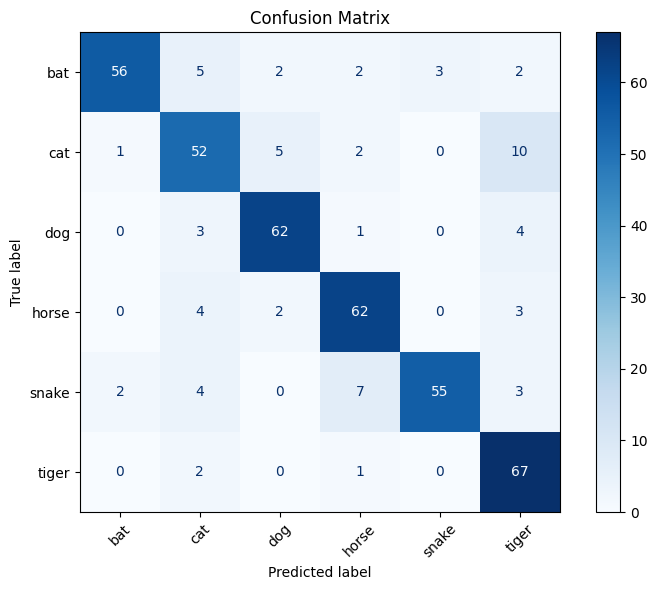

In [ ]:
class_names = list(label_to_idx.keys())  

cm = confusion_matrix(all_labels, all_preds)

fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
ax.set_title("Confusion Matrix")
plt.tight_layout()
plt.show()